# 독립변수를 다항식으로 변환 후 표준화 진행 결과

## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures    #다항식 변환 모듈

## #02. 데이터셋 준비

In [2]:
origin = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
origin.head()

,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


## #03. 데이터 전처리

### 결측치 확인

isna().sum()

> 이미 다른 예제에서 진행된 절차이므로 생략

## #04. 탐색적 데이터 분석

### 기본통계 확인

describe()

> 이미 다른 예제에서 진행된 절차이므로 생략

### 산점도 그래프와 추세선 확인

산점도, 추세선 확인 이유
- 단순선형, 다항식으로 갈지 여부를 결정 -> 곡선인 경우 다항식으로 분석
- 이상 징후를 식별
- 한 변수가 다른 변수에 어떤 영향을 미치는지 확인
- 상관 관계, 패턴, 추세 또는 관계 보기

In [3]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

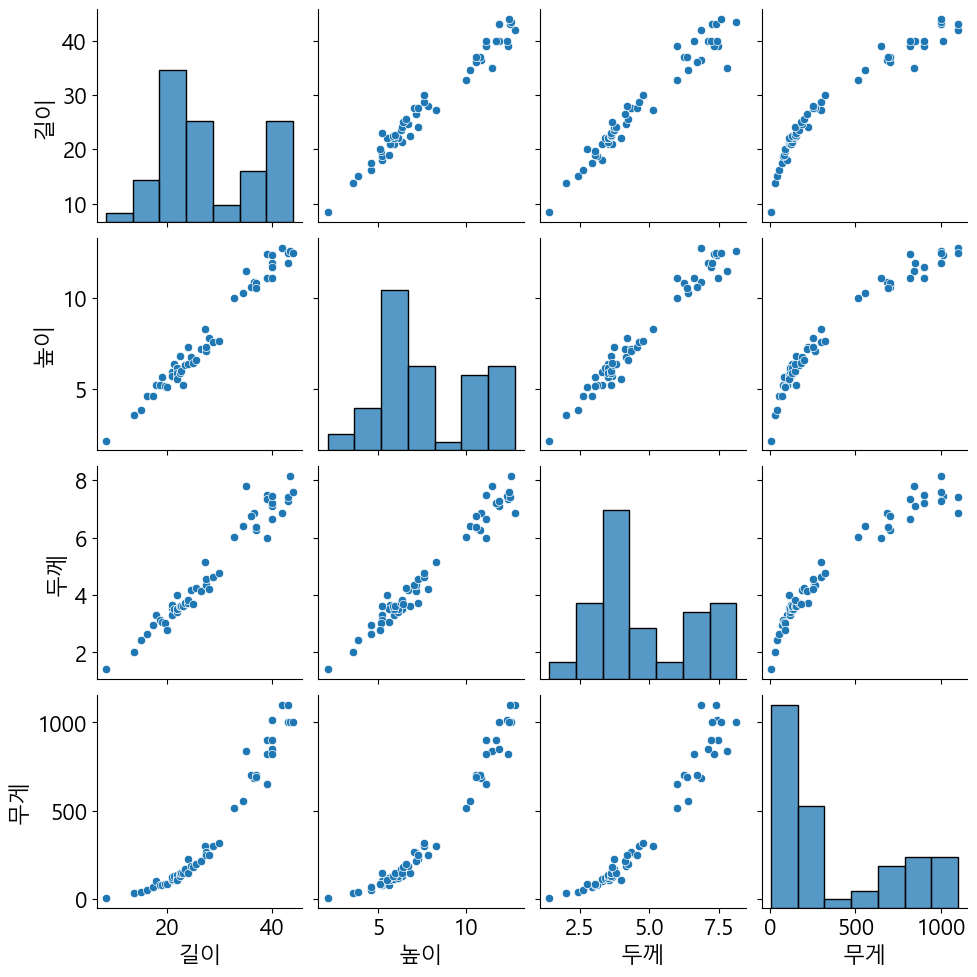

In [4]:
plt.figure(figsize=(30, 30))
sb.pairplot(origin)
plt.show()
plt.close()

> 산점도 그래프의 형태로 보아 다항식이 적합하다고 판단.

## #05. 데이터셋 분할

### 랜덤시드 고정

In [5]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [6]:
origin.columns

Index(['길이', '높이', '두께', '무게'], dtype='object')

In [7]:
x = origin[['길이', '높이', '두께']]
y = origin[['무게']]
# (행 수, 열 수)
x.shape, y.shape

((56, 3), (56, 1))

### 독립변수를 다항식으로 변환

In [8]:
poly = PolynomialFeatures(degree=2, include_bias=False)
fit = poly.fit_transform(x)
x2 = DataFrame(fit, columns=poly.get_feature_names_out())
x2.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2
0,8.4,2.11,1.41,70.56,17.724,11.844,4.4521,2.9751,1.9881
1,13.7,3.53,2.00,187.69,48.361,27.400,12.4609,7.0600,4.0000
2,15.0,3.82,2.43,225.00,57.300,36.450,14.5924,9.2826,5.9049
3,16.2,4.59,2.63,262.44,74.358,42.606,21.0681,12.0717,6.9169
4,17.4,4.59,2.94,302.76,79.866,51.156,21.0681,13.4946,8.6436


### 데이터 표준화

- 통계에서는 종속변수 표준화를 권장하지 않음
- 예측 값을 역 표준화 해야하지 때문
- 단, 머신러닝 선능을 위해서는 권장

In [9]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x2)

# y_scaller = StandardScaler()
# y_scale = y_scaller.fit_transform(y)
# x_scale.shape, y_scale.shape

# (행 수, 열 수)
x_scale.shape

(56, 9)

### 훈련 데이터와 검증 데이터로 분할

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 9), (17, 9), (39, 1), (17, 1))

## #06. 모델 개발

### 모델 정의

In [11]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

### 학습하기

학습하기를 실행할 수록 모델의 학습 성능이 변화

In [12]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
2/2 [==============================] - 1s 239ms/step - loss: 283532.5000 - mae: 395.5531 - val_loss: 221690.1562 - val_mae: 350.9275 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 37ms/step - loss: 283397.5000 - mae: 395.3990 - val_loss: 221589.8594 - val_mae: 350.7947 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 40ms/step - loss: 283276.2500 - mae: 395.2582 - val_loss: 221496.7500 - val_mae: 350.6732 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 41ms/step - loss: 283162.9375 - mae: 395.1289 - val_loss: 221405.5469 - val_mae: 350.5606 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 43ms/step - loss: 283060.3750 - mae: 395.0075 - val_loss: 221317.6406 - val_mae: 350.4553 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 41ms/step - loss: 282949.7500 - mae: 394.8921 - val_loss: 221233.4688 - val_mae: 350.3516 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 46m

## #07. 학습 결과 평가

In [13]:
# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,283532.500000,395.553070,221690.156250,350.927490,0.001
2,283397.500000,395.398987,221589.859375,350.794678,0.001
3,283276.250000,395.258209,221496.750000,350.673248,0.001
4,283162.937500,395.128906,221405.546875,350.560638,0.001
5,283060.375000,395.007538,221317.640625,350.455261,0.001
...,...,...,...,...,...
167,10294.504883,83.643692,12634.882812,75.447884,0.001
168,10227.665039,83.101540,12667.950195,74.998558,0.001
169,10177.125000,82.581352,12701.266602,74.570793,0.001


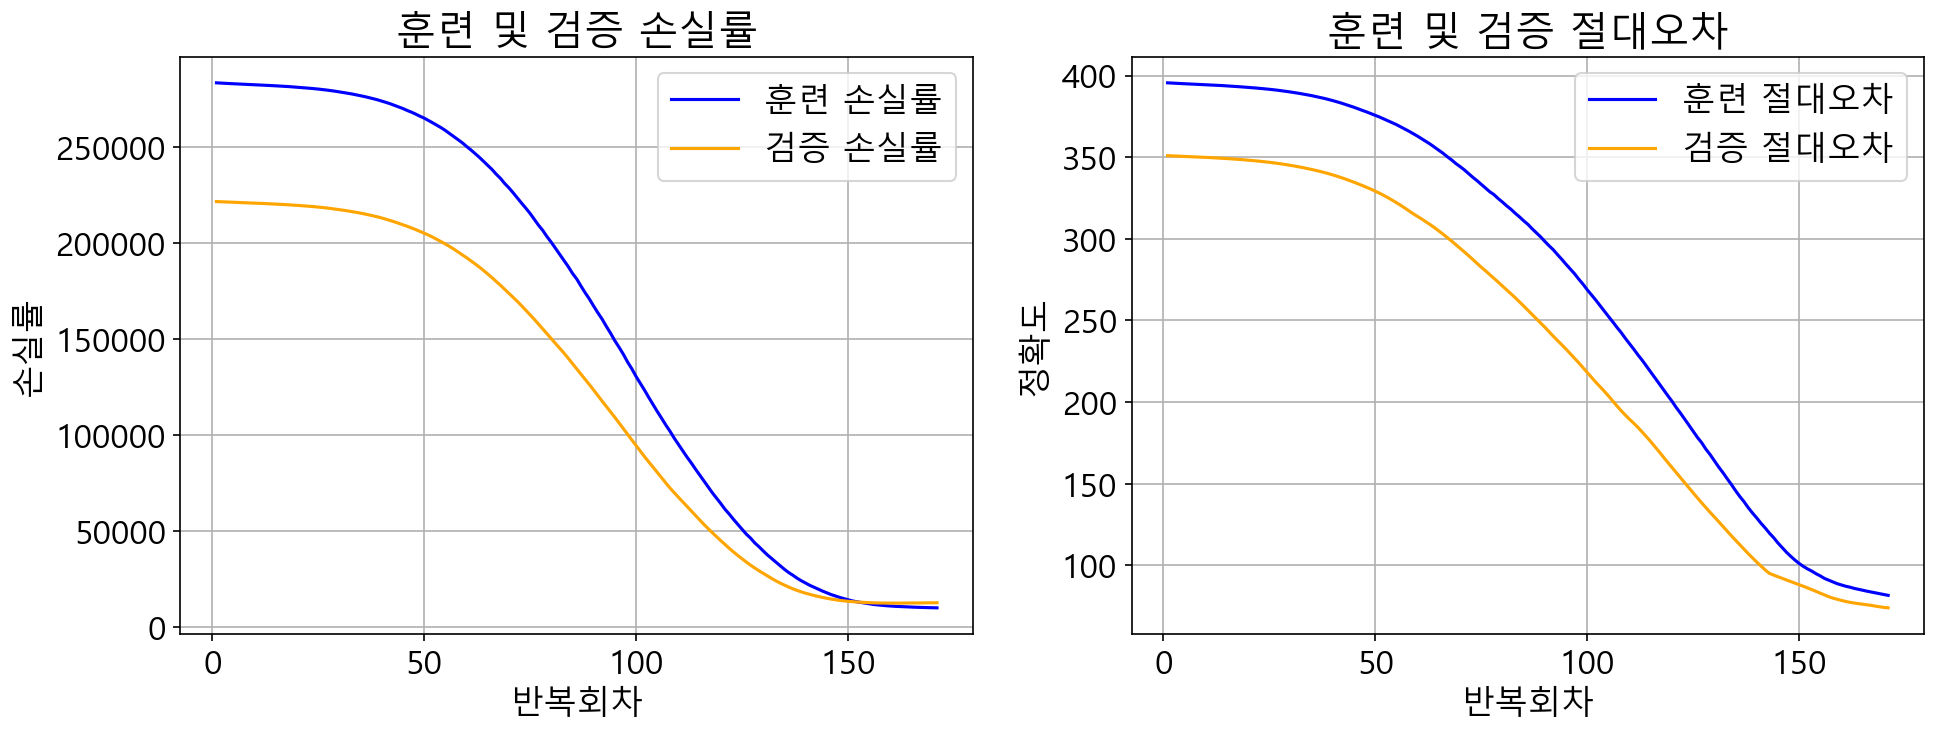

In [14]:
# ------------------------------
# 그래프를 그리기 위한 객체 생성
# ------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
# ------------------------------
# 1) 훈련 및 검증 손실 그리기
# ------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()
# ------------------------------
# 2) 훈련 및 검증 절대오차 그리기
# ------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [15]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 7ms/step - loss: 10041.0947 - mae: 81.3119
최종 훈련 손실률: 10041.094727, 최종 훈련 절대오차: 81.311890
1/1 [==============================] - 0s 33ms/step - loss: 12727.4004 - mae: 73.9480
최종 검증 손실률: 12727.400391, 최종 검증 절대오차: 73.948013


## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [16]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 25ms/step


### 결과 데이터 셋 구성

- 표준화를 거치면 numpy 배열 형태(1차원 데이터 배열) -> [0]로 열 길이 출력 가능
- 표준화를 진행하지 않으면 DF 형태(2차원 형태) -> iloc[0]로 열 길이 출력 가능
- type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능
>- Series, numpy 객체는 1차원 데이터 배열. 다만, numpy는 다차원 배열에도 적용이 가능
>- DF 형태는 Flatten 형태 불가 -> 2차원 형태

In [17]:
x2.columns

Index(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께', '두께^2'], dtype='object')

In [28]:
train_df = DataFrame(x_train, columns=x2.columns)
# train_df['무게(관측치)'] = y_train #본인 코드
train_df['무게(관측치)'] = y_train['무게'].values
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차(잔차)'] = train_df['무게(관측치)'] - train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차(잔차)
0,-0.927534,-0.954292,-0.969558,-0.901344,-0.905194,-0.910571,-0.902581,-0.905521,-0.901350,85.0,132.420639,-47.420639
1,-2.180225,-2.016507,-1.896175,-1.497943,-1.428186,-1.403939,-1.358064,-1.335908,-1.300665,5.9,190.222336,-184.322336
2,-0.659101,-0.779008,-0.696689,-0.711407,-0.758186,-0.726039,-0.790823,-0.761706,-0.728004,120.0,114.142097,5.857903
3,-0.368297,-0.396891,-0.327179,-0.480910,-0.496891,-0.466210,-0.511254,-0.482346,-0.452830,188.0,83.791061,104.208939
4,1.577847,1.731046,1.207709,1.723689,1.846825,1.455565,1.946749,1.554578,1.188140,1100.0,990.945618,109.054382


In [30]:
test_df = DataFrame(x_test, columns=x2.columns)
# test_df['무게(관측치)'] = y_test  #본인 코드
test_df['무게(관측치)'] = y_test['무게'].values
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차(잔차)'] = test_df['무게(관측치)'] - test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차(잔차)
0,-0.659101,-0.614242,-0.696689,-0.711407,-0.693048,-0.726039,-0.676317,-0.705421,-0.728004,130.0,109.745224,20.254776
1,-0.770948,-0.761480,-0.611417,-0.793211,-0.787101,-0.729863,-0.779077,-0.726681,-0.668631,125.0,112.842827,12.157173
2,-0.580807,-0.670333,-0.634156,-0.651880,-0.688985,-0.674770,-0.716326,-0.702314,-0.684706,145.0,107.515778,37.484222
3,-0.043940,-0.204080,-0.099788,-0.193473,-0.278660,-0.227557,-0.351486,-0.305248,-0.260371,250.0,62.036716,187.963284
4,0.235678,-0.084887,0.013907,0.079999,-0.099752,-0.047479,-0.246445,-0.200537,-0.157535,320.0,76.024857,243.975143


### 실제 결과값과 머신러닝에 의한 예측값 비교

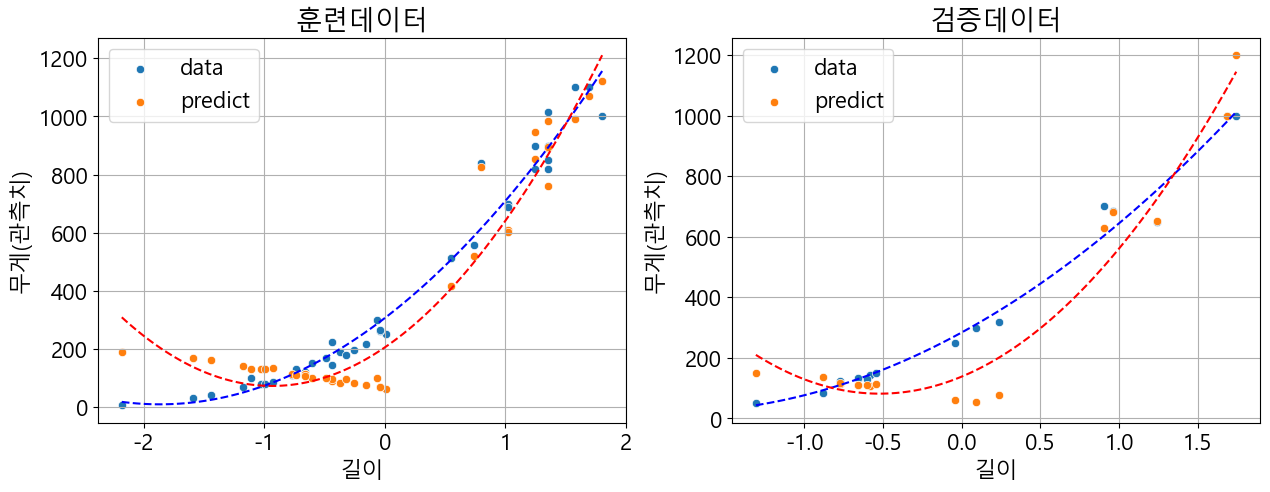

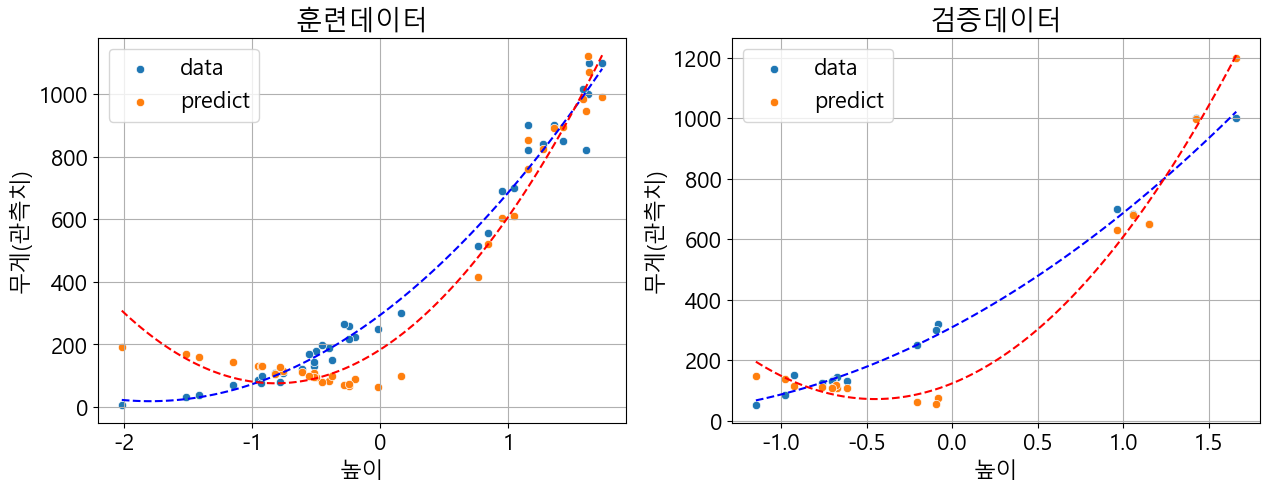

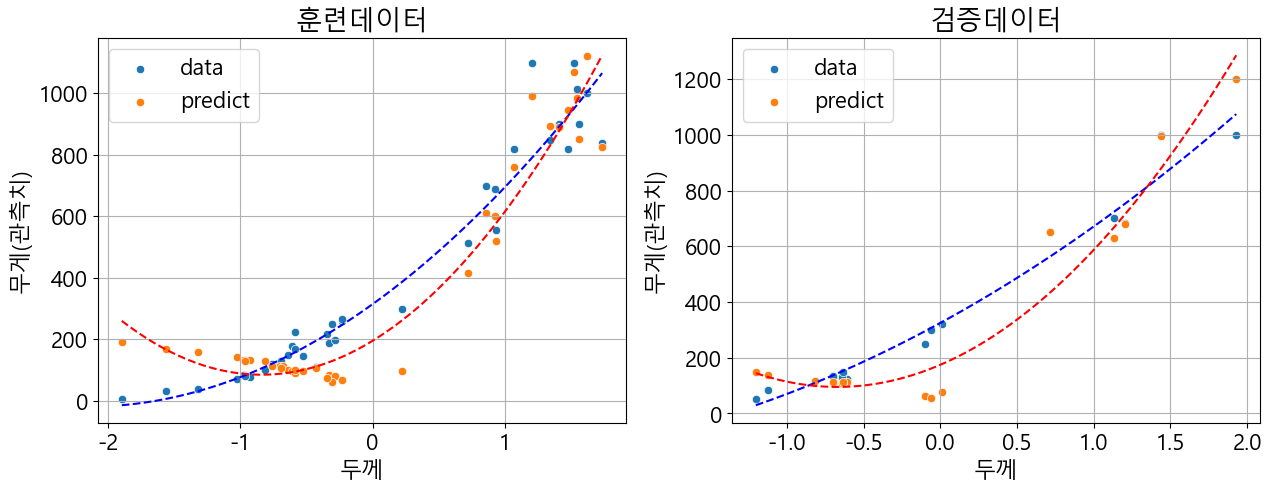

In [20]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))

# `모듈 사용`

## #07. 학습 결과 평가

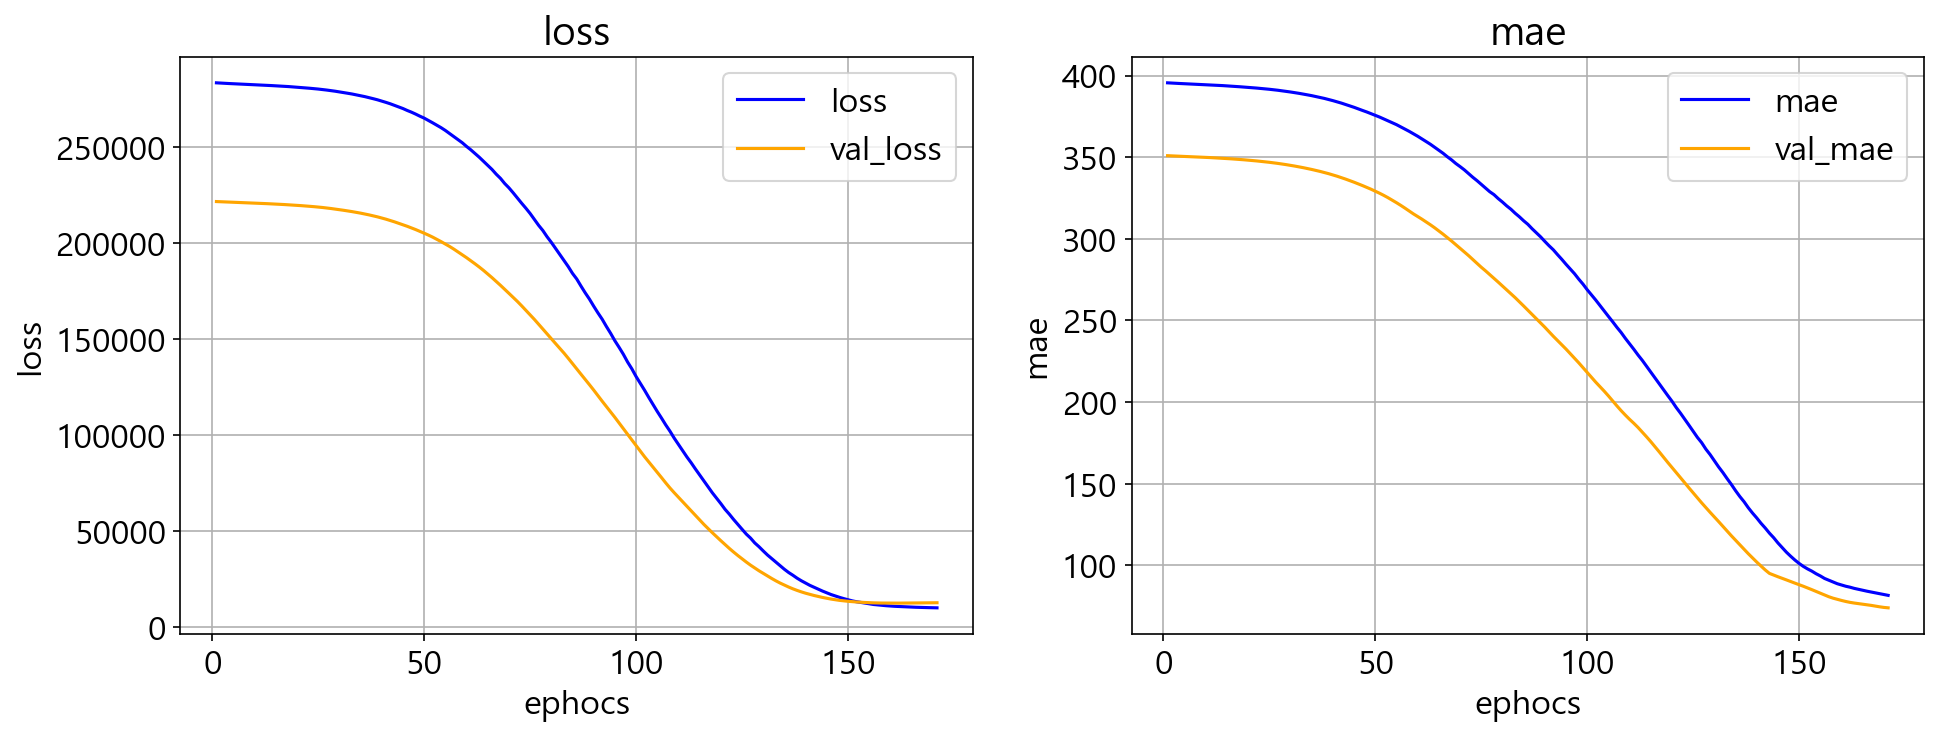

2/2 [==============================] - 0s 5ms/step - loss: 10041.0947 - mae: 81.3119
최종 훈련 손실률: 10041.094727, 최종 훈련 절대오차 : 81.311890
1/1 [==============================] - 0s 30ms/step - loss: 12727.4004 - mae: 73.9480
최종 검증 손실률: 12727.400391, 최종 검증 절대오차 : 73.948013


In [21]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차 : %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차 : %f" % (evaluate2[0], evaluate2[1]))

## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [22]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 33ms/step


### 결과 데이터 셋 구성

In [23]:
x2.columns

Index(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께', '두께^2'], dtype='object')

In [24]:
train_df = DataFrame(x_train, columns=x2.columns)
train_df['무게(관측치)'] = y_train['무게'].values
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)']-train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
0,-0.927534,-0.954292,-0.969558,-0.901344,-0.905194,-0.910571,-0.902581,-0.905521,-0.901350,85.0,132.420639,-47.420639
1,-2.180225,-2.016507,-1.896175,-1.497943,-1.428186,-1.403939,-1.358064,-1.335908,-1.300665,5.9,190.222336,-184.322336
2,-0.659101,-0.779008,-0.696689,-0.711407,-0.758186,-0.726039,-0.790823,-0.761706,-0.728004,120.0,114.142097,5.857903
3,-0.368297,-0.396891,-0.327179,-0.480910,-0.496891,-0.466210,-0.511254,-0.482346,-0.452830,188.0,83.791061,104.208939
4,1.577847,1.731046,1.207709,1.723689,1.846825,1.455565,1.946749,1.554578,1.188140,1100.0,990.945618,109.054382


In [25]:
test_df = DataFrame(x_test, columns=x2.columns)
test_df['무게(관측치)'] = y_test['무게'].values
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)']-test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
0,-0.659101,-0.614242,-0.696689,-0.711407,-0.693048,-0.726039,-0.676317,-0.705421,-0.728004,130.0,109.745224,20.254776
1,-0.770948,-0.761480,-0.611417,-0.793211,-0.787101,-0.729863,-0.779077,-0.726681,-0.668631,125.0,112.842827,12.157173
2,-0.580807,-0.670333,-0.634156,-0.651880,-0.688985,-0.674770,-0.716326,-0.702314,-0.684706,145.0,107.515778,37.484222
3,-0.043940,-0.204080,-0.099788,-0.193473,-0.278660,-0.227557,-0.351486,-0.305248,-0.260371,250.0,62.036716,187.963284
4,0.235678,-0.084887,0.013907,0.079999,-0.099752,-0.047479,-0.246445,-0.200537,-0.157535,320.0,76.024857,243.975143


### 실제 결과값과 머신러닝에 의한 예측값 비교

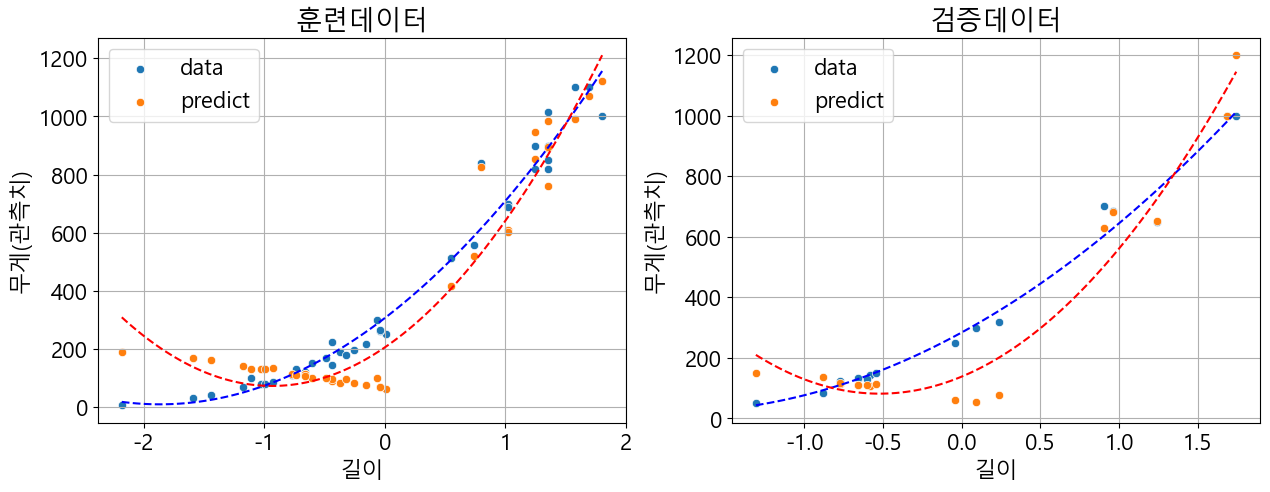

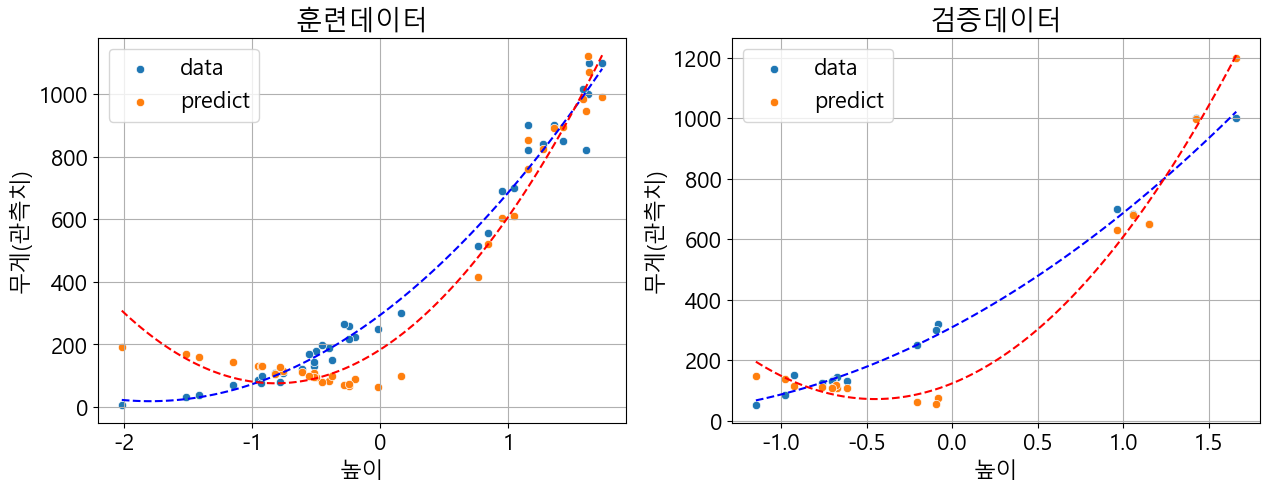

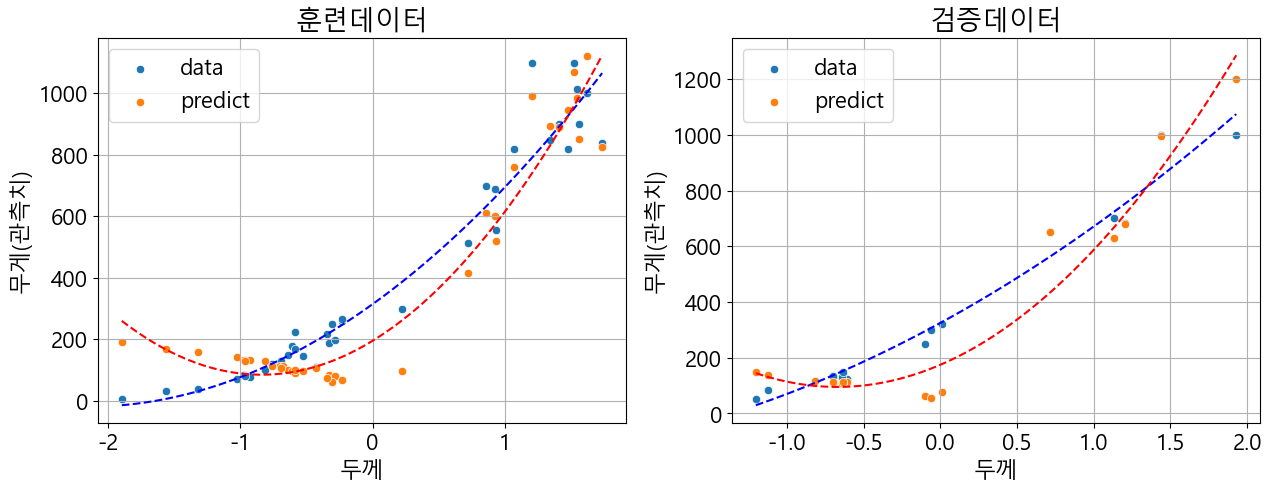

In [26]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))